In [24]:
!pip install pandas matplotlib scikit-learn ta --quiet

In [25]:
import pandas as pd
import numpy as np

In [26]:
# Upload the CSV manually from Kaggle or local
from google.colab import files
uploaded = files.upload()

Saving solana.csv to solana.csv


In [27]:
sol = pd.read_csv("solana.csv")
sol.head()

,Day,Open,High,Low,Close,Volume,Market Cap
0,13/06/2025,150.7870,150.7870,141.6950,148.5533,1.445933e+10,7.650353e+10
1,12/06/2025,160.9195,161.1955,152.2381,152.6924,1.052319e+10,8.315863e+10
2,11/06/2025,165.3555,168.2250,159.5039,161.1399,1.344592e+10,8.655679e+10
3,10/06/2025,160.9914,165.4861,156.8950,165.0063,1.023983e+10,8.404210e+10
4,09/06/2025,152.7359,161.5602,149.9132,161.1158,7.123536e+09,8.102114e+10


In [30]:
print(sol.columns)

Index(['Day', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market_Cap'], dtype='object')


In [31]:
# Rename columns
sol.columns = ['Day', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market_Cap']

# Convert 'Day' to datetime
sol['Day'] = pd.to_datetime(sol['Day'], dayfirst=True)

# Sort the data in chronological order
sol = sol.sort_values('Day').reset_index(drop=True)

# (Optional) Check data types
print(sol.dtypes)

Day           datetime64[ns]
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume               float64
Market_Cap           float64
dtype: object


Feature Engineering (These features help the model understand trends, volatility, and previous behavior.)

In [54]:
# 1. Daily Return: % change from previous close to today
sol['Daily_Return'] = sol['Close'].pct_change()

# 2. Volatility: 14-day rolling standard deviation of Daily Return
sol['Volatility'] = sol['Daily_Return'].rolling(window=14).std()

# 3. Dynamic Label based on Volatility Threshold
def dynamic_label(row):
    if row['Daily_Return'] > row['Volatility']:
        return 2  # Up
    elif row['Daily_Return'] < -row['Volatility']:
        return 0  # Down
    else:
        return 1  # Flat

sol['Target_dynamic'] = sol.apply(dynamic_label, axis=1)

# 4. Drop rows with NaN values created by rolling or pct_change
sol = sol.dropna(subset=['Daily_Return', 'Volatility', 'Target_dynamic']).reset_index(drop=True)
sol['MA7'] = sol['Close'].rolling(window=7).mean()
sol['MA21'] = sol['Close'].rolling(window=21).mean()


In [56]:
sol['Target_dynamic'] = sol.apply(dynamic_label, axis=1)

# Drop rows with NaNs introduced by pct_change() and rolling
sol = sol.dropna(subset=['Volatility', 'Daily_Return', 'Target_dynamic']).reset_index(drop=True)

# Optional: View class distribution
print("Class distribution:\n", sol['Target_dynamic'].value_counts(normalize=True))

Class distribution:
 Target_dynamic
1    0.701907
2    0.168392
0    0.129700
Name: proportion, dtype: float64


In [57]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Market_Cap']


In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

def walk_forward_validation(df, feature_cols, target_col, train_years, test_year):
    train_df = df[df['Day'].dt.year.isin(train_years)]
    test_df = df[df['Day'].dt.year == test_year]

    X_train = train_df[feature_cols]
    y_train = train_df[target_col]
    X_test = test_df[feature_cols]
    y_test = test_df[target_col]

    from xgboost import XGBClassifier

    model = XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)

    print(f"\n📅 Train Years: {train_years}, Test Year: {test_year}, Accuracy: {acc:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["Down", "Flat", "Up"]))

    return model, X_test, y_test, acc


In [95]:
accuracies = []

for test_year in range(2023, 2026):
    train_years = list(range(2020, test_year))
    model, X_test, y_test, acc = walk_forward_validation(sol, features, 'Target_dynamic', train_years, test_year)
    accuracies.append((test_year, acc))

# Print final results
print("\n📈 Walk-forward Accuracies:")
for year, acc in accuracies:
    print(f"{year}: {acc:.4f}")



📅 Train Years: [2020, 2021, 2022], Test Year: 2023, Accuracy: 0.9562

Classification Report:
              precision    recall  f1-score   support

        Down       1.00      0.76      0.86        41
        Flat       0.94      1.00      0.97       263
          Up       1.00      0.90      0.95        61

    accuracy                           0.96       365
   macro avg       0.98      0.89      0.93       365
weighted avg       0.96      0.96      0.95       365


📅 Train Years: [2020, 2021, 2022, 2023], Test Year: 2024, Accuracy: 0.9672

Classification Report:
              precision    recall  f1-score   support

        Down       1.00      0.90      0.95        51
        Flat       0.95      1.00      0.98       245
          Up       1.00      0.90      0.95        70

    accuracy                           0.97       366
   macro avg       0.98      0.93      0.96       366
weighted avg       0.97      0.97      0.97       366


📅 Train Years: [2020, 2021, 2022, 2023, 202

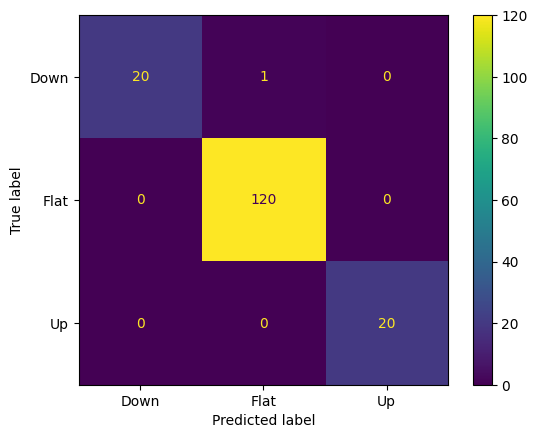

In [84]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=["Down", "Flat", "Up"])
